## Assignment 2 - Clustering

## Learning Outcomes

In this assignment, you will do the following:

* Explore a dataset and carry out clustering using k-means algorithm

* Identify the optimum number of clusters for a given dataset



## Problem Description

In this assignment, you will study the electricity demand from clients in Portugal, during 2013 and 2014. You have been provided with the data file, which you should download when you download this assignment file.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise, you will use clustering techniques to understand the typical usage behaviour during 2013-2014.

Both these datasets are publicly available, and can be used to carry out experiments. Their source is below:

 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm

We will start by exploring the data set and continue on to the assignment.  Consider this as a working notebook, you will add your work to the same notebook.

In this assignment we will use the sklearn package for k-means.  Please refer here for the documentation https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
(https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

The sklearn package for k-means is one of the many clustering algorithms found in the module "sklearn.cluster".  These come with a variety of functions that you can call by importing the package.

For example 
    
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import KMeans



## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed. The data file has been provided with this assignment. It is also available at the links provided above.

In [1]:
import os
print(os.getcwd())

pathToFile = r"C:\\Users\\megda\\OneDrive\\Documents\\My_Projects\\Machine Learning\\A2\\assignment2-data\\assignment2-data\\"

#pathToFile = r"C:\\path\\to\\file\\"
#pathToFile = r"C:\\Users\\<your username>\\Downloads\\"

fileName = 'LD2011_2014.txt'

C:\Users\megda\OneDrive\Documents\My_Projects\Machine Learning\A2


In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

import pandas as pd #for Dataframe append

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [7]:
data.shape

(140256, 370)

#### As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [9]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the first 2 days of 2012 for the first 2 clients

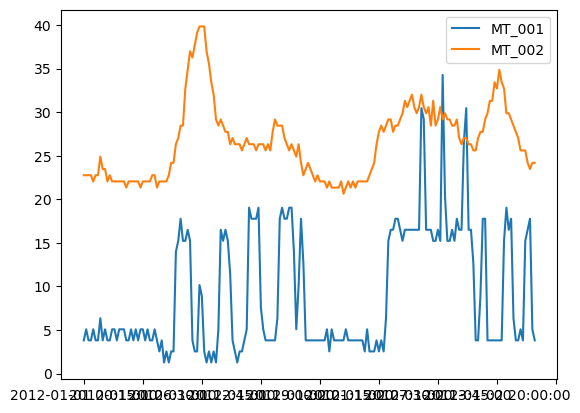

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We  note that the main difference between the curves is the level (also seen on the means in df.describe()).  We know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [15]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand

#data_13_14 = data2013.append(data2014) # appending 2013 and 2014
#Append no longer works for pandas 2.0+
data_13_14 = pd.concat([data2013, data2014])

data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [16]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [17]:
data['hour'] = data.index.map(lambda x: x[11:])

In [18]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [19]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [20]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

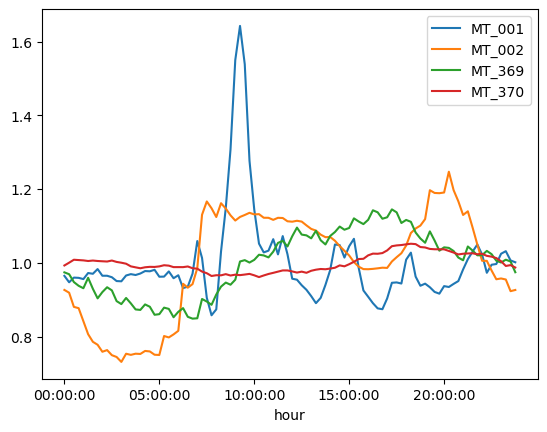

In [21]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [22]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format
X.view() #349 columns linked with clients and 96 rows (per day meaning all of these points are for 1 day)

array([[0.96479215, 0.94737834, 0.96010381, ..., 1.03176835, 1.00665227,
        1.00162906],
       [0.92667365, 0.91911689, 0.8807438 , ..., 0.95492484, 0.9233459 ,
        0.92656966],
       [0.99179969, 0.97779638, 0.9765787 , ..., 1.00397648, 0.99849693,
        0.99301737],
       ...,
       [1.17044059, 1.22381837, 1.21134255, ..., 1.17431116, 1.15378816,
        1.13637963],
       [0.97430716, 0.96926554, 0.94796904, ..., 1.00867049, 1.00368029,
        0.97461078],
       [0.99296729, 1.00054813, 1.00851498, ..., 0.99165659, 0.99394714,
        0.98743097]], shape=(349, 96))

# Questions (15 marks total)

**Q1: (7 marks)**

a. Determine what a convenient number of clusters. Justify your choice.  Make use of the sklearn's package for k-means for this. You may refer to the module to figure out how to come up with the optimal number of clusters. 

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the center of the cluster (make this curve thicker to distinguish it from the individual curves).  The center is also sometimes referred to as "centroid".
    
You have 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [29]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

**Q2: (8 marks)**

In this exercise you work with the daily curves of 1 single client.
First, create a list of arrays, each array containing a curve for a day. You may use X from the cells above.
    X = average_curves_norm.copy() 
The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value of k ( number of clusters). This time you may also perform silhoutte analysis as stated in the module. Carrying out silhoutte analysis is left as an exercise. What do you understand about the clusters? 

b. Based on your results from your analyses of both methods, what do understand?  Interpret it perhaps with different perspectives of timelines like weeks or months.

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b).  The cells below are only to give you a headstart.  You may or may not use these and come up with your own interpretation.


In [35]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [0]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

Continue with your analysis here:

C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklea

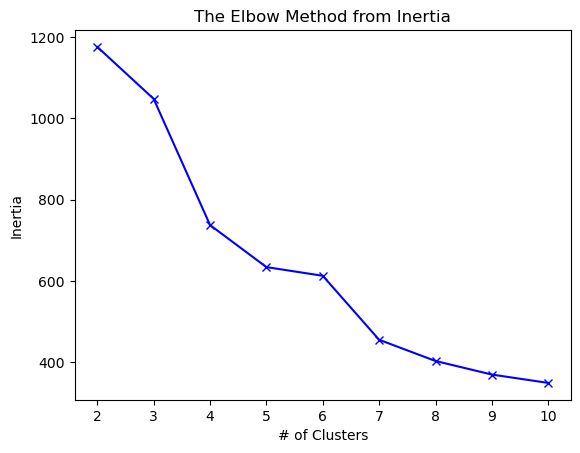

In [23]:
###Q1.
##a.Determine what a convenient number of clusters. Justify your choice. Make use of the sklearn's package for k-means for this. 
##You may refer to the module to figure out how to come up with the optimal number of clusters. 
#Using inertia values by testing cluster values between 2 and 10 to determine the most advantageous k value

inertia = [] #sum of squared error for each cluster

cluster_tests = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for k_test in cluster_tests:
    kmeans = KMeans(n_clusters=k_test, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(cluster_tests, inertia, 'bx-')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method from Inertia')
plt.show()

C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


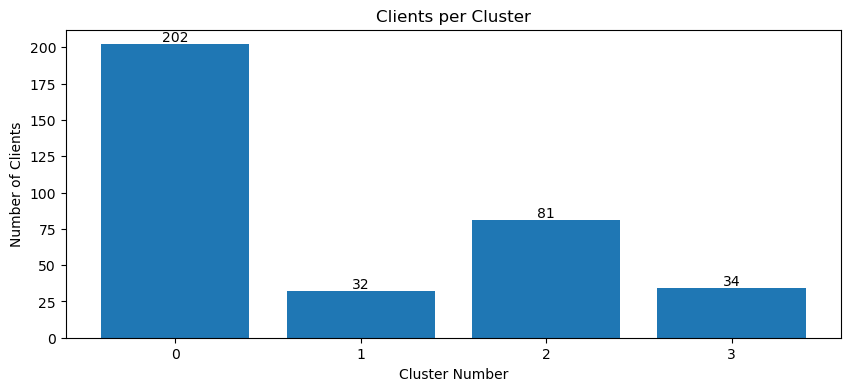

In [24]:
#Based on the elbow graph formed above, a number of 4 clusters would most likely be best as it has the closest "bend"

##b. Make a plot for each cluster, that includes: - The number of clients in the cluster (you can put this in the title of the 
##plot) - All the curves in the cluster - The curve corresponding to the center of the cluster (make this curve thicker to 
##distinguish it from the individual curves). The center is also sometimes referred to as "centroid".
k_value = 4

kmeans = KMeans(n_clusters=k_value, random_state=0).fit(X)
labels = kmeans.labels_ # Get the cluster labels for each data point


#The number of clients in each cluster
clusters = [0] * k_value #based on chosen number of clusters
cluster_label = list(range(k_value))

for client in labels:
    clusters[client] = clusters[client] + 1
    
colors = 'bgryckm'


#bar graph showing number in each cluster
plt.figure(figsize=(10, k_value))
plt.bar(list(range(len(clusters))), clusters, color=list(colors[:k_value]))
plt.xticks(cluster_label)


clust_count = plt.subplot()
lab_plt = clust_count.bar(cluster_label, clusters)

# Add labels to the bars
clust_count.bar_label(lab_plt)

plt.title('Clients per Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Clients')
plt.show()

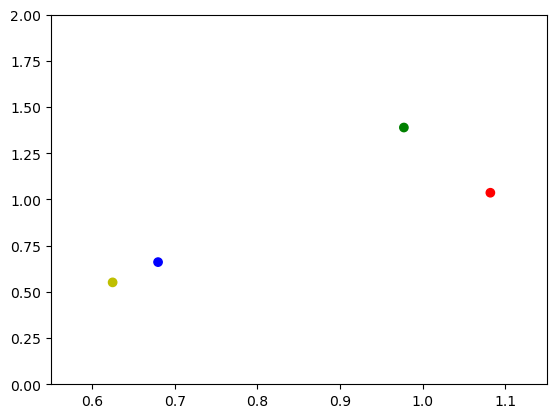

In [25]:
#All the curves in the cluster - The curve corresponding to the center of the cluster
#Plot centroids

centroids = kmeans.cluster_centers_

plt.scatter(centroids[:,0],centroids[:,1], color=list(colors[:k_value]))
plt.xlim(0.55,1.15)
plt.ylim(0.0,2.0)
plt.show()


C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


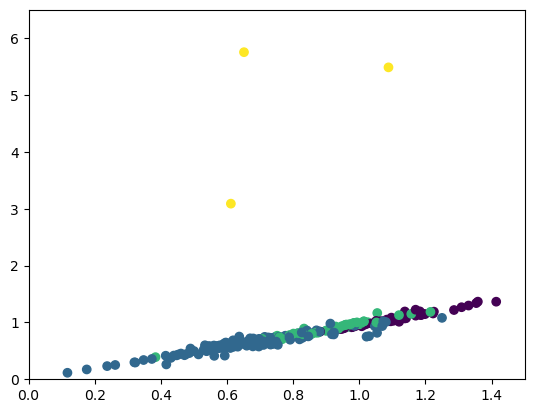

In [26]:
#Plot the cluster curves

y_pred = KMeans(n_clusters=k_value, random_state=1).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.xlim(0.0,1.5)
plt.ylim(0.0,6.5)
plt.show()

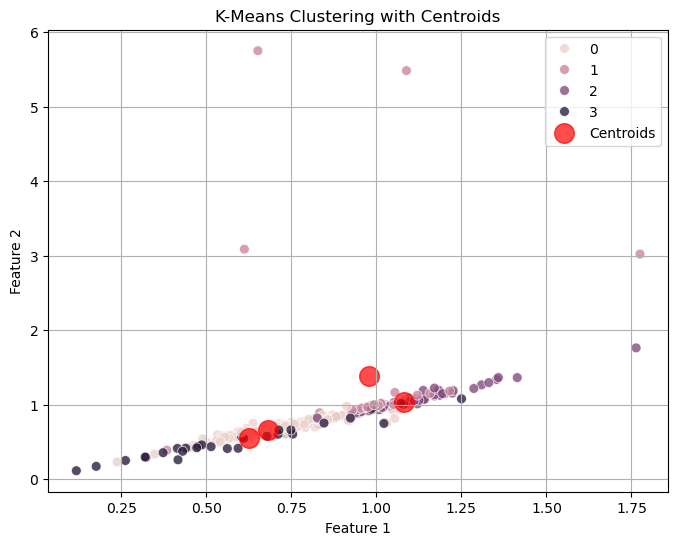

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, s=50, alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.7, label='Centroids')
plt.title('K-Means Clustering with Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
#Because this data is non spherical, I also checked using DBSCAN, which revealed that 4 clustes was optimal
#Use DBSCAN to properly show curves for non-sperical data

from sklearn.cluster import DBSCAN

db = DBSCAN(min_samples=5, eps=0.5).fit(X)

# Cluster labels (-1 means noise)
dblabels = db.labels_

n_clusters = len(set(dblabels)) - (1 if -1 in dblabels else 0)
n_labels = set(dblabels)

print(n_clusters)

4


C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklea

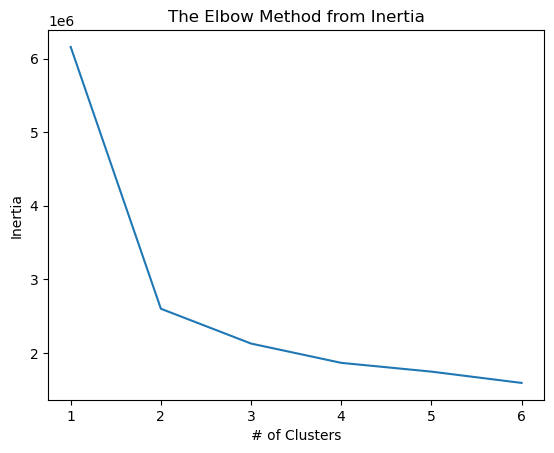

In [30]:
##Q2. 
#a. Determine the optimal value of k ( number of clusters). This time you may also perform silhoutte analysis as stated in the 
#module. Carrying out silhoutte analysis is left as an exercise. What do you understand about the clusters?

from sklearn import metrics

clusters = [1, 2, 3, 4, 5, 6]

#Elbow graph using inertia method
inertia2 = [] #sum of squared error for each cluster

for k_test in clusters:
    kmeans = KMeans(n_clusters=k_test, random_state=0)
    kmeans.fit(X)
    inertia2.append(kmeans.inertia_)
    
plt.plot(clusters, inertia2)
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method from Inertia')
plt.show()

#From the elbow graph, when 1 cluster is also included, k value of 2 is optimal as it is the bend in the curve


In [31]:
#Silhouette method

clusters = [2, 3, 4, 5, 6]

for c in clusters:
    test_kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    test_labels = test_kmeans.labels_
    print(c)
    print(metrics.silhouette_score(X, test_labels, metric='euclidean'))
    
#Because a larger silhouette coefficient is preferable, meaning better defined clusters, when sampling between 2 and 10 clusters,
#The most optimal number of clusters to use for this problem is 2 as it has the largest coefficient with 0.501 (rf3) although this
#value needs improvement.

k_value = 2

C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklea

2
0.5011374240143707
3
0.282197741615619
4
0.21352696378921662
5
0.21844461895679204
6
0.20035272113315233


C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [32]:
kmeans = KMeans(n_clusters=k_value, random_state=42).fit(X)
labels = kmeans.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


np.float64(0.5011374240143707)

C:\Users\megda\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


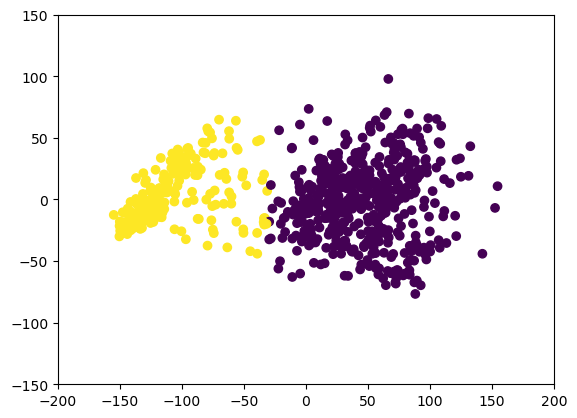

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) #Bring to 2 dimensions, list of arrays is not two dim
X_fit = pca.fit_transform(X)

y_pred = KMeans(n_clusters=2).fit_predict(X)

plt.scatter(X_fit[:, 0], X_fit[:, 1], c=y_pred)
plt.xlim(-200.0,200.0)
plt.ylim(-150.0,150.0)
plt.show()

#From these 2 clusters for this one client over the course of 2013 and 2014 I can deduce that there is a tight relationship for
#for the yellow cluster and a looser relationship for the purple cluster.
#This could mean that there was a clear discrepency of house much electricity was demanded between the two years. This client could
#have needed more in sporatic fashion.

In [36]:
##b. Based on your results from your analyses of both methods, what do understand? Interpret it perhaps with different 
##perspectives of timelines like weeks or months.

print(len(X))
print(len(daysyear))
print(daysyear[0:10])

#The length of the single clients data and the days in the span of 2013-2014 is the same, meaning that each day in daysyear lines
#up with a data point in X.

#A comparing the electricity usage on weekdays vs weekends may show a discrepancy like what can be seen in the clusters formed

730
730
['tue-2013-01-01', 'wed-2013-01-02', 'thu-2013-01-03', 'fri-2013-01-04', 'sat-2013-01-05', 'sun-2013-01-06', 'mon-2013-01-07', 'tue-2013-01-08', 'wed-2013-01-09', 'thu-2013-01-10']


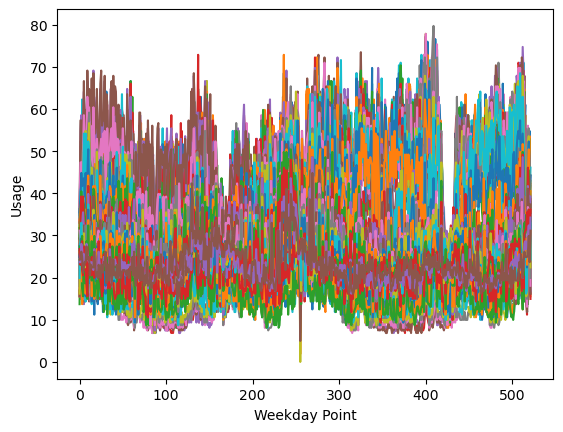

In [37]:
weekday = []
weekend = []

weekend_days = ['sat', 'sun']

#find each weekday and weekend days usage and put them in different lists
for electricity, day in zip(X, daysyear):
    if day.split("-")[0] in weekend_days:
        weekend.append(electricity)
    else:
        weekday.append(electricity)
        
plt.plot(weekday)
plt.ylabel("Usage")
plt.xlabel("Weekday Point")
plt.show()

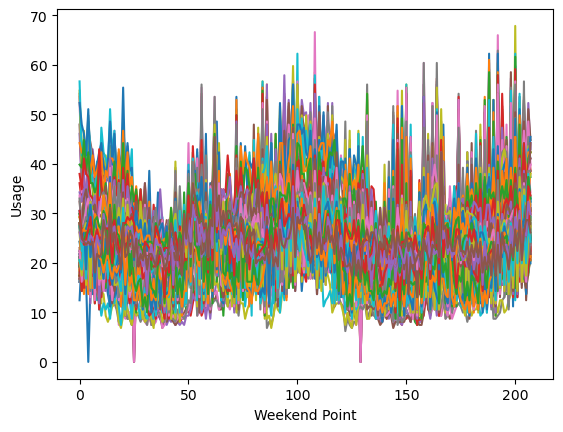

In [38]:
plt.plot(weekend)
plt.ylabel("Usage")
plt.xlabel("Weekend Point")
plt.show()

In [ ]:
#The data plotted in the Weekday plot is higher on average, ignoring the volume, the trend appears slightly greater than that
#of the Weekend plot.